In [3]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [19]:
data_test = pd.read_parquet('./customer_data.parquet')
data_test.to_csv('./customer_data.csv', index=False)

KeyboardInterrupt: 

In [20]:
data_test = pd.read_parquet('./customer_data.parquet')
data_test = data_test[data_test['category_code'].isin(['electronics.smartphone'])]
data_test.drop(columns=['user_session', 'category_id', 'category_code'], inplace=True)

data_test.to_parquet('mytestdata.parquet', index=False, engine='pyarrow', compression='snappy')

In [21]:
data_test.to_csv('./testdata.csv', index=False)

In [4]:
# Load data and filter by date range
customer_data = pd.read_parquet('./mytestdata.parquet')

# customer_data = customer_data[customer_data['category_code'].isin(['electronics.smartphone'])]
# customer_data.drop(columns=['user_session'], inplace=True)


customer_data.head()

,event_time,event_type,product_id,brand,price,user_id
0,2019-10-01 00:00:04 UTC,view,1004237,apple,1081.98,535871217
1,2019-10-01 00:00:11 UTC,view,1004545,huawei,566.01,537918940
2,2019-10-01 00:00:11 UTC,view,1005011,samsung,900.64,530282093
3,2019-10-01 00:00:19 UTC,view,1005135,apple,1747.79,535871217
4,2019-10-01 00:00:20 UTC,view,1003306,apple,588.77,555446831


In [33]:
# # # Filter for only 'cart' and 'purchase' events
# customer_data = customer_data[customer_data['event_type'].isin(['cart', 'remove_from_cart','purchase'])]

In [1]:
len(customer_data)

NameError: name 'customer_data' is not defined

In [7]:
# Data Preprocessing
customer_data.isna().sum()

event_time        0
event_type        0
product_id        0
brand         21910
price             0
user_id           0
dtype: int64

In [5]:
# Vectorized filling of missing brand values for product_id using apply()
def fill_missing_brand(group):
    if group['brand'].notna().any():
        group['brand'] = group['brand'].fillna(method='ffill').fillna(method='bfill')
    return group

customer_data = customer_data.groupby('product_id').apply(fill_missing_brand).reset_index(drop=True)

C:\Users\DEBATRA\AppData\Local\Temp\ipykernel_19016\558997619.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group['brand'] = group['brand'].fillna(method='ffill').fillna(method='bfill')
C:\Users\DEBATRA\AppData\Local\Temp\ipykernel_19016\558997619.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  customer_data = customer_data.groupby('product_id').apply(fill_missing_brand).reset_index(drop=True)
C:\Users\DEBATRA\AppData\Local\Temp\ipykernel_19016\558997619.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas t

In [6]:
# Data Preprocessing
customer_data.isna().sum()

event_time      0
event_type      0
product_id      0
brand         413
price           0
user_id         0
dtype: int64

In [7]:
customer_data.dropna()
len(customer_data)

11507231

In [8]:
customer_data.describe()

,product_id,price,user_id
count,1.150723e+07,1.150723e+07,1.150723e+07
mean,1.004555e+06,4.719471e+02,5.358182e+08
std,7.179385e+02,4.029040e+02,1.892236e+07
min,1.000978e+06,0.000000e+00,2.262430e+08
25%,1.004266e+06,1.792100e+02,5.166440e+08
50%,1.004833e+06,2.831200e+02,5.352214e+08
75%,1.005021e+06,7.213400e+02,5.549544e+08
max,1.005278e+06,2.110450e+03,5.662807e+08


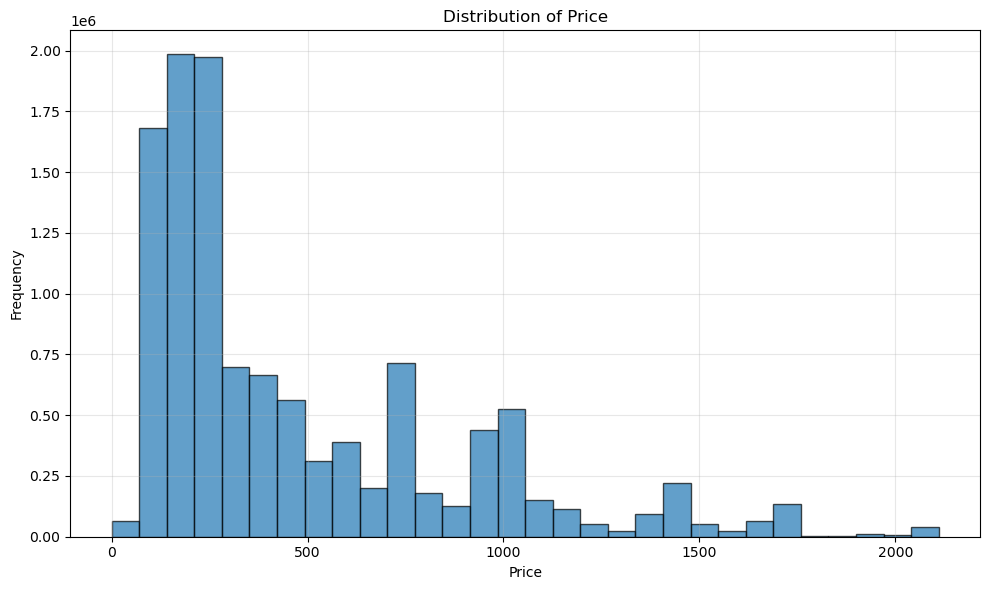

In [47]:

# Plot histogram for price
plt.figure(figsize=(10, 6))
plt.hist(customer_data['price'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Group customer_data by user_id
customer_groups = customer_data.groupby('user_id')
print(f"Number of unique users: {customer_groups.ngroups}")
customer_groups.size().head(10)

Number of unique users: 1300236


user_id
226242984     1
231943435     1
236306098     3
239876607    18
241587569     1
241784978     1
244951053    10
249183593     1
258811396     3
263428680     1
dtype: int64

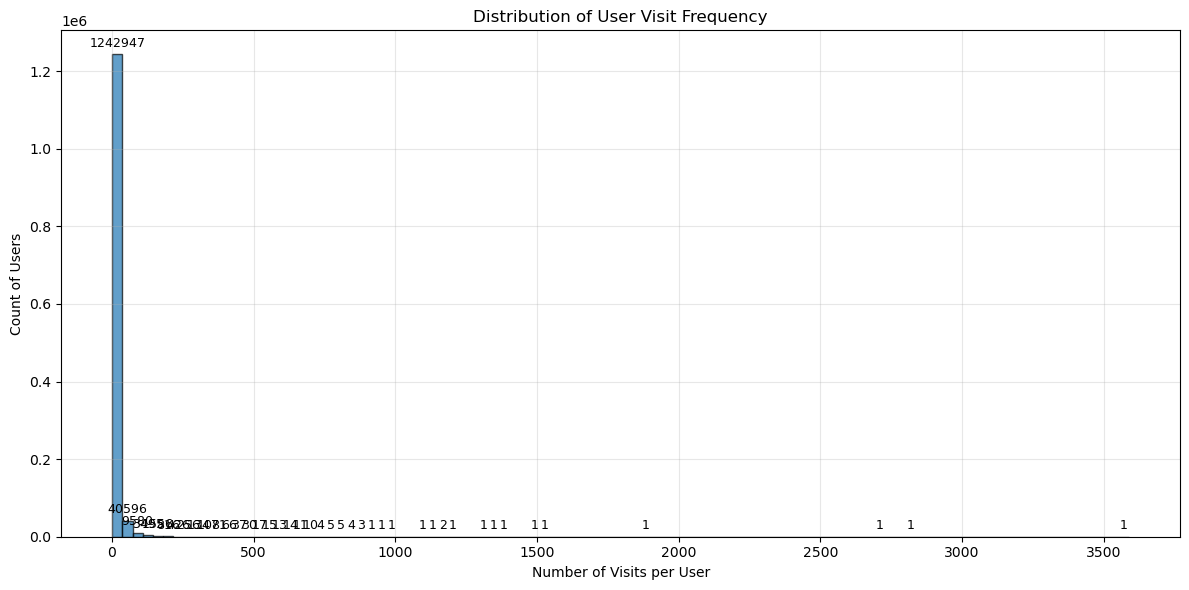

In [16]:
# Plot histogram of number of visits by user
user_visit_counts = customer_groups.size()

plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(user_visit_counts, bins=100, edgecolor='black', alpha=0.7)

# Add count labels above each bar
for i in range(len(n)):
    if n[i] > 0:  # Only show label if there are users in this bin
        plt.text(bins[i] + (bins[i+1] - bins[i])/2, n[i] + max(n)*0.01, 
                int(n[i]), ha='center', va='bottom', fontsize=9)

plt.xlabel('Number of Visits per User')
plt.ylabel('Count of Users')
plt.title('Distribution of User Visit Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### There are some outlier users regarding number of visits to the website in Oct 2019.

In [17]:
# Display statistics
print(f"Total users: {len(user_visit_counts)}")
print(f"Average visits per user: {user_visit_counts.mean():.2f}")
print(f"Median visits per user: {user_visit_counts.median():.2f}")
print(f"Std visits per user: {user_visit_counts.std():.2f}")
print(f"Max visits by a user: {user_visit_counts.max()}")
print(f"Min visits by a user: {user_visit_counts.min()}")

Total users: 1300236
Average visits per user: 8.85
Median visits per user: 3.00
Std visits per user: 19.63
Max visits by a user: 3590
Min visits by a user: 1


### Clustering based on user visits

In [14]:
# Standard Scaling the data

scaler = StandardScaler()
visit_counts_scaled = scaler.fit_transform(user_visit_counts.values.reshape(-1, 1))

# 3. K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(visit_counts_scaled)

# 4. Assign cluster labels
user_clusters = pd.DataFrame({
    'user_id': user_visit_counts.index,
    'visit_count': user_visit_counts.values,
    'cluster': clusters
})

# 5. View cluster distribution
print(user_clusters['cluster'].value_counts())

cluster
0    1177831
1     109631
3      12225
2        549
Name: count, dtype: int64


In [62]:
# Analyze clusters
print(user_clusters.groupby('cluster')['visit_count'].describe())

             count        mean         std    min    25%    50%    75%     max
cluster                                                                       
0        1177831.0    4.749111    4.661812    1.0    1.0    3.0    6.0    21.0
1         109631.0   37.555874   14.638794   22.0   26.0   33.0   45.0    82.0
2            549.0  455.728597  268.309259  292.0  329.0  385.0  476.0  3590.0
3          12225.0  126.470184   43.742985   83.0   94.0  112.0  145.0   291.0


### Clustering based on average price per user

Average price statistics:
Mean: $523.57
Median: $371.69
Std: $402.62
Max: $2110.45
Min: $0.00


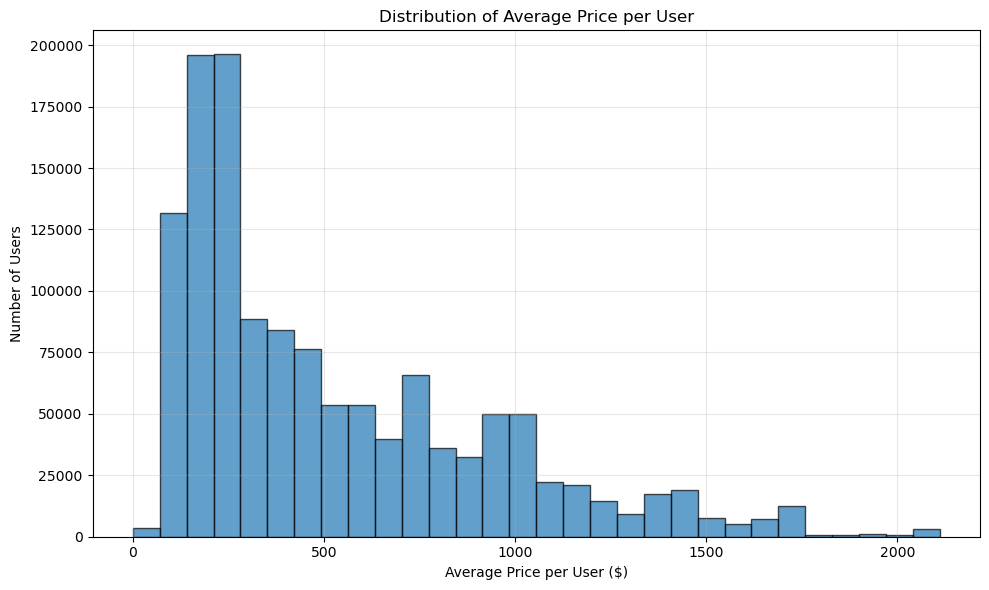

In [64]:
# Calculate average price per user
user_avg_price = customer_groups['price'].mean()

print(f"Average price statistics:")
print(f"Mean: ${user_avg_price.mean():.2f}")
print(f"Median: ${user_avg_price.median():.2f}")
print(f"Std: ${user_avg_price.std():.2f}")
print(f"Max: ${user_avg_price.max():.2f}")
print(f"Min: ${user_avg_price.min():.2f}")

# Plot histogram of average prices
plt.figure(figsize=(10, 6))
plt.hist(user_avg_price, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Average Price per User ($)')
plt.ylabel('Number of Users')
plt.title('Distribution of Average Price per User')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [65]:
# Standard scaling for average price
price_scaler = StandardScaler()
avg_price_scaled = price_scaler.fit_transform(user_avg_price.values.reshape(-1, 1))

# K-means clustering on average price
price_kmeans = KMeans(n_clusters=4, random_state=42)
price_clusters = price_kmeans.fit_predict(avg_price_scaled)

# Create DataFrame with price cluster results
user_price_clusters = pd.DataFrame({
    'user_id': user_avg_price.index,
    'avg_price': user_avg_price.values,
    'price_cluster': price_clusters
})

# View price cluster distribution
print("Price cluster distribution:")
print(user_price_clusters['price_cluster'].value_counts())

# Analyze price clusters
print("\nPrice cluster analysis:")
print(user_price_clusters.groupby('price_cluster')['avg_price'].describe())

Price cluster distribution:
price_cluster
0    683920
2    311015
1    218447
3     86854
Name: count, dtype: int64

Price cluster analysis:
                  count         mean         std          min          25%  \
price_cluster                                                                
0              683920.0   222.231878   80.586055     0.000000   154.366259   
1              218447.0   985.014697  117.290078   782.988571   898.090000   
2              311015.0   583.822715  113.703465   402.108000   475.292644   
3               86854.0  1520.055901  195.370229  1251.756667  1379.610000   

                       50%          75%          max  
price_cluster                                         
0               216.212083   273.599732   402.105000  
1               977.524286  1058.300000  1251.755000  
2               576.080000   695.120870   782.987344  
3              1428.350000  1670.410000  2110.450000  


C:\Users\DEBATRA\AppData\Local\Temp\ipykernel_28860\3506829444.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\DEBATRA\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


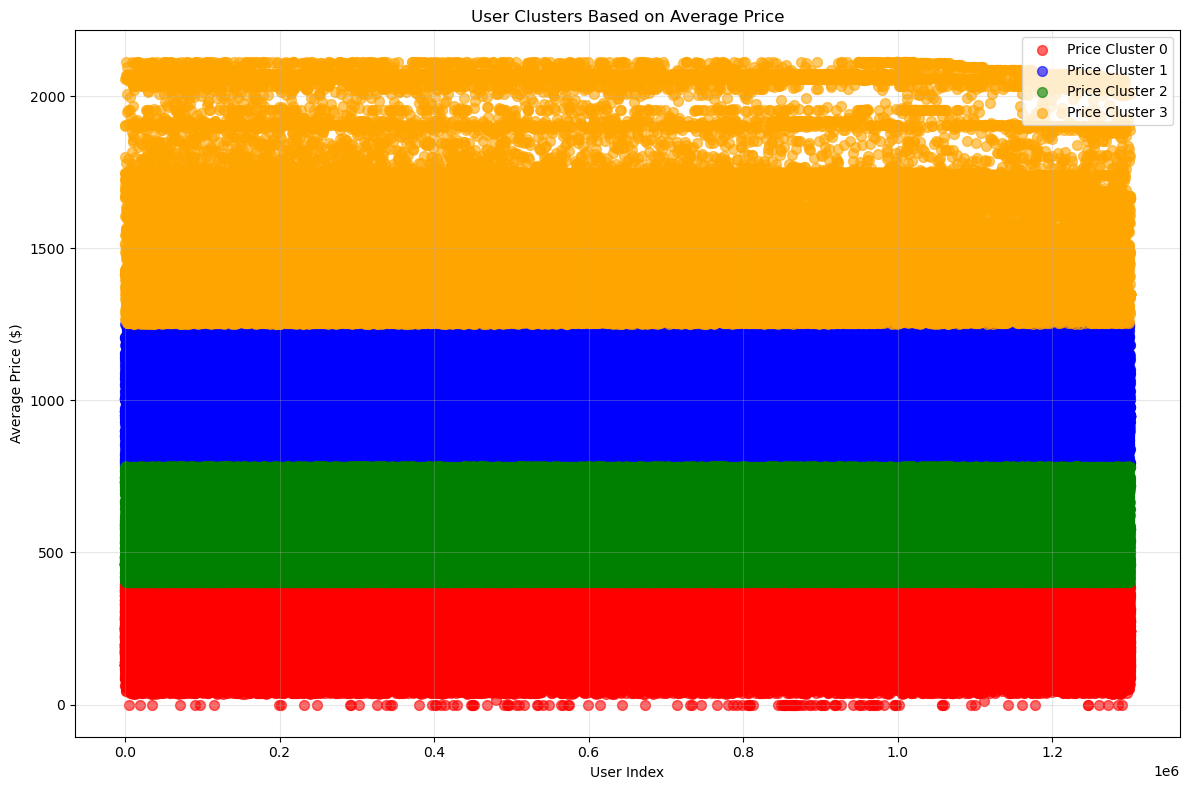

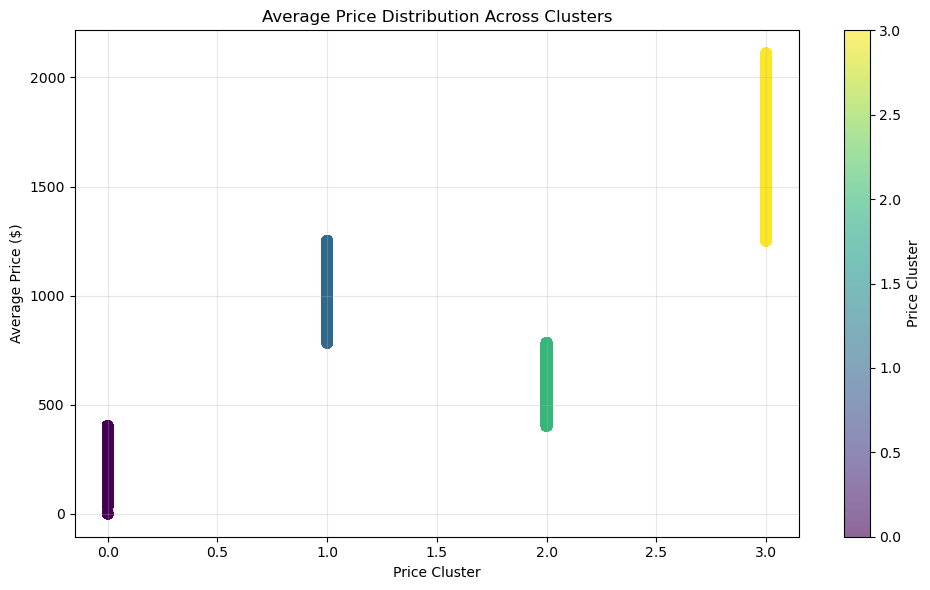

In [66]:
# Visualize price clusters
plt.figure(figsize=(12, 8))

# Create scatter plot for price clusters
colors = ['red', 'blue', 'green', 'orange']
cluster_labels = ['Price Cluster 0', 'Price Cluster 1', 'Price Cluster 2', 'Price Cluster 3']

for i in range(4):
    cluster_data = user_price_clusters[user_price_clusters['price_cluster'] == i]
    plt.scatter(cluster_data.index, cluster_data['avg_price'], 
               c=colors[i], label=cluster_labels[i], alpha=0.6, s=50)

plt.xlabel('User Index')
plt.ylabel('Average Price ($)')
plt.title('User Clusters Based on Average Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Alternative view - price cluster vs average price
plt.figure(figsize=(10, 6))
plt.scatter(user_price_clusters['price_cluster'], user_price_clusters['avg_price'], 
           c=user_price_clusters['price_cluster'], cmap='viridis', alpha=0.6, s=50)
plt.xlabel('Price Cluster')
plt.ylabel('Average Price ($)')
plt.title('Average Price Distribution Across Clusters')
plt.colorbar(label='Price Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
def calculate_kmeans(k):
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    clusters_test = kmeans_test.fit_predict(avg_price_scaled)
    return kmeans_test, clusters_test

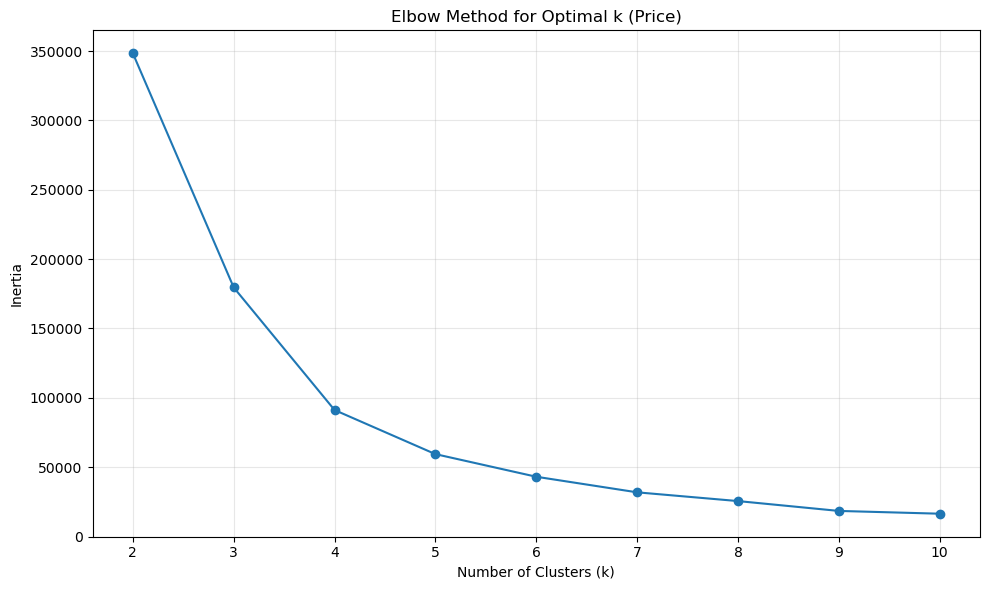

Inertia values for different k:
k=2: 348404.93
k=3: 179576.55
k=4: 91199.74
k=5: 59407.03
k=6: 43095.29
k=7: 31858.60
k=8: 25553.26
k=9: 18448.57
k=10: 16444.18


In [72]:
# Find optimal number of clusters for price using Elbow Method - Vectorized with .apply()
k_range = range(2, 11)

# Vectorized approach using pandas Series and apply
k_series = pd.Series(k_range)
inertias = k_series.apply(lambda k: calculate_kmeans(k)[0].inertia_).tolist()

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (Price)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Inertia values for different k:")
for k, inertia in zip(k_range, inertias):
    print(f"k={k}: {inertia:.2f}")

In [83]:
# Generate silhouette scores to find optimal number of clusters for price
from sklearn.metrics import silhouette_score

k_range = range(2, 11)
silhouette_scores = []

for k in k_range:
    silhouette_scores.append(silhouette_score(avg_price_scaled, calculate_kmeans(k)[1], sample_size=10000, random_state=42))




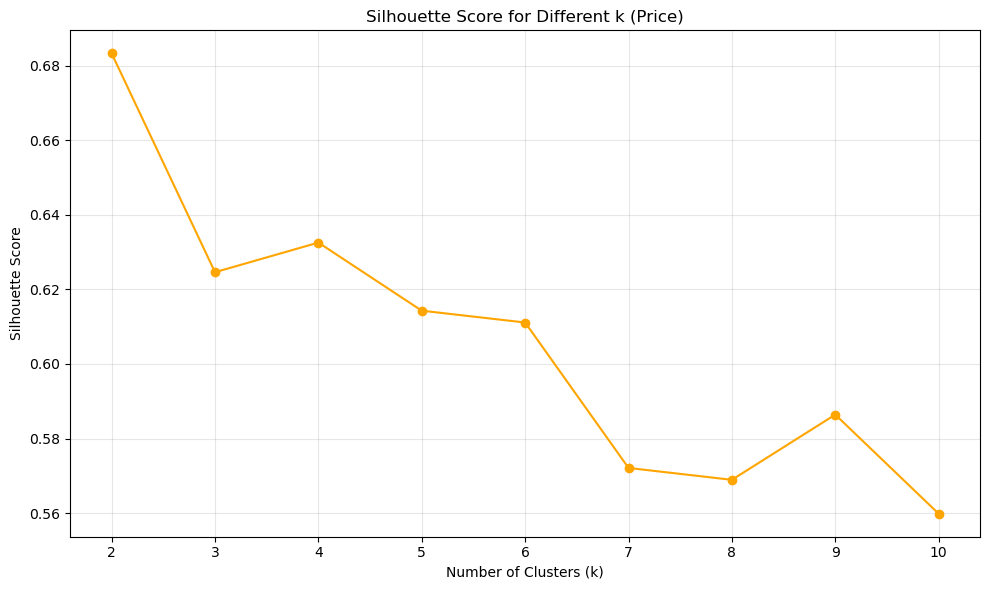

In [84]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k (Price)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [86]:
# Comprehensive analysis and recommendation for optimal clusters
# Find optimal k based on silhouette score
optimal_k_silhouette = k_range[silhouette_scores.index(max(silhouette_scores))]
max_silhouette = max(silhouette_scores)

optimal_k_silhouette, max_silhouette

(2, 0.6832917027932535)

In [87]:

# Calculate elbow point (look for the biggest drop in inertia reduction)
inertia_drops = [inertias[i] - inertias[i+1] for i in range(len(inertias)-1)]
elbow_k = k_range[inertia_drops.index(max(inertia_drops))] + 1

elbow_k

3

In [1]:
#Pranav - Price and Event-type

from sklearn.preprocessing import OneHotEncoder

df_mix = customer_data[['price', 'event_type']].copy()

# 2. One-hot encode event_type
encoder = OneHotEncoder(sparse_output=False)
event_encoded = encoder.fit_transform(df_mix[['event_type']])
event_columns = encoder.get_feature_names_out(['event_type'])

# 3. Combine price (numeric) with encoded event_type (binary)
combined_df = pd.concat(
    [df_mix[['price']].reset_index(drop=True),
     pd.DataFrame(event_encoded, columns=event_columns)],
    axis=1
)

# 4. Scale all features together
scaler = StandardScaler()
combined_scaled = scaler.fit_transform(combined_df)

# 5. Run K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(combined_scaled)

# 6. Attach cluster labels to original data
df_mix['cluster'] = clusters

# 7. Inspect cluster composition
print(df_mix.groupby('cluster').agg({
    'price': 'mean',
    'event_type': lambda x: x.value_counts().index[0]  # most common event
}))

NameError: name 'customer_data' is not defined

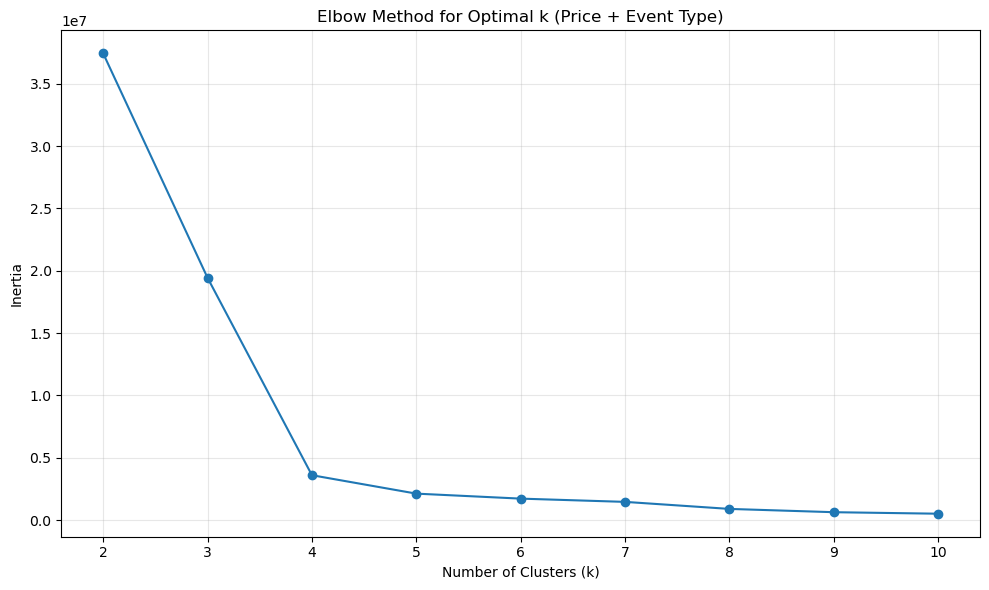

Inertia values for different k:
k=2: 37432061.56
k=3: 19435352.85
k=4: 3605226.24
k=5: 2128137.04
k=6: 1727901.18
k=7: 1466969.46
k=8: 902713.38
k=9: 639089.31
k=10: 518609.66


In [13]:
#Generating Elbow

k_range = range(2, 11)
inertias = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(combined_scaled)
    inertias.append(km.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (Price + Event Type)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print inertia values
print("Inertia values for different k:")
for k, inertia in zip(k_range, inertias):
    print(f"k={k}: {inertia:.2f}")

In [14]:
# 1. Select brand & event_type
df_mix = customer_data[['brand', 'event_type']]

# 2. One-hot encode BOTH brand and event_type
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_mix[['brand', 'event_type']])
encoded_columns = encoder.get_feature_names_out(['brand', 'event_type'])

In [15]:
# # 3. Scale encoded features
# scaler = StandardScaler()
# encoded_scaled = scaler.fit_transform(encoded_features)

# 4. Run K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(encoded_features)

# 5. Attach cluster labels to original data
df_mix['cluster'] = clusters



C:\Users\DEBATRA\AppData\Local\Temp\ipykernel_23464\1067581795.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mix['cluster'] = clusters


In [16]:
# 6. Inspect cluster composition
print(df_mix.groupby('cluster').agg({
    'brand': lambda x: x.value_counts().index[0],       # most common brand
    'event_type': lambda x: x.value_counts().index[0]   # most common event
}))

           brand event_type
cluster                    
0         xiaomi       view
1          apple       view
2        samsung       view
3         huawei       view


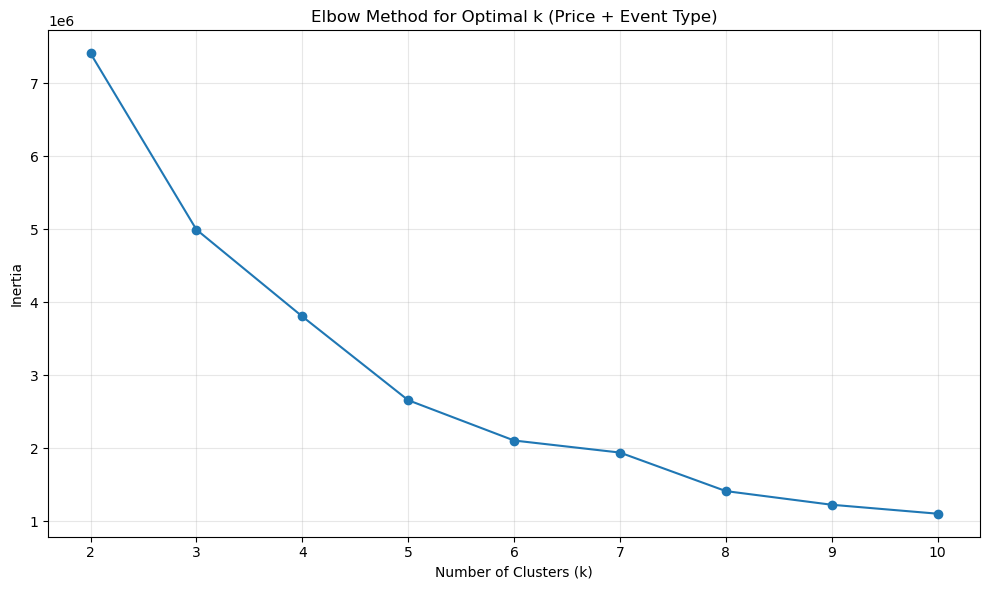

Inertia values for different k:
k=2: 7409537.91
k=3: 4994563.13
k=4: 3804544.47
k=5: 2657136.88
k=6: 2104788.68
k=7: 1939569.32
k=8: 1411745.34
k=9: 1224469.38
k=10: 1101897.42


In [18]:
#Generating Elbow

k_range = range(2, 11)
inertias = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit_predict(encoded_features)
    inertias.append(km.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (Price + Event Type)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print inertia values
print("Inertia values for different k:")
for k, inertia in zip(k_range, inertias):
    print(f"k={k}: {inertia:.2f}")

In [19]:
# 4. Run K-Means clustering
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(encoded_features)

# 5. Attach cluster labels to original data
df_mix['cluster'] = clusters

# 6. Inspect cluster composition
print(df_mix.groupby('cluster').agg({
    'brand': lambda x: x.value_counts().index[0],       # most common brand
    'event_type': lambda x: x.value_counts().index[0]   # most common event
}))

C:\Users\DEBATRA\AppData\Local\Temp\ipykernel_23464\1424139761.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mix['cluster'] = clusters


           brand event_type
cluster                    
0         xiaomi       view
1        samsung       view
2          apple       view
3         huawei       view
4          meizu       view
5           oppo       view
6        samsung       cart
7        samsung   purchase


### Advanced User Behavior Clustering
Creating comprehensive user segments using visit frequency, engagement ratio, and brand diversity

In [20]:
# Step 1: Calculate user-level features
print("Calculating user-level features...")

# Group by user_id and calculate metrics
user_metrics = customer_data.groupby('user_id').agg({
    'event_type': ['count'],  # Total interactions (visit frequency)
    'brand': 'nunique'        # Number of unique brands
}).reset_index()

# Flatten column names
user_metrics.columns = ['user_id', 'visit_frequency', 'brand_interactions']

# Calculate event type counts per user
event_counts = customer_data.groupby(['user_id', 'event_type']).size().unstack(fill_value=0).reset_index()

# Merge with user metrics
user_features = user_metrics.merge(event_counts, on='user_id', how='left')

# Calculate view-to-action ratio: (cart + purchase) / view
# Handle division by zero by setting ratio to 0 when view count is 0
user_features['view_to_action_ratio'] = np.where(
    user_features['view'] > 0,
    (user_features.get('cart', 0) + user_features.get('purchase', 0)) / user_features['view'],
    0
)

# Display the features we'll use for clustering
clustering_features = user_features[['user_id', 'visit_frequency', 'view_to_action_ratio', 'brand_interactions']].copy()

print("User features summary:")
print(clustering_features.describe())
print(f"\nTotal users: {len(clustering_features)}")
print(f"Features for clustering: visit_frequency, view_to_action_ratio, brand_interactions")

Calculating user-level features...
User features summary:
            user_id  visit_frequency  view_to_action_ratio  brand_interactions
count  1.300236e+06     1.300236e+06          1.300236e+06        1.300236e+06
mean   5.404025e+08     8.850110e+00          8.492129e-02        1.618326e+00
std    1.938297e+07     1.962631e+01          3.140619e-01        1.319014e+00
min    2.262430e+08     1.000000e+00          0.000000e+00        0.000000e+00
25%    5.199924e+08     1.000000e+00          0.000000e+00        1.000000e+00
50%    5.443545e+08     3.000000e+00          0.000000e+00        1.000000e+00
75%    5.583284e+08     9.000000e+00          0.000000e+00        2.000000e+00
max    5.662807e+08     3.590000e+03          4.500000e+01        3.100000e+01

Total users: 1300236
Features for clustering: visit_frequency, view_to_action_ratio, brand_interactions


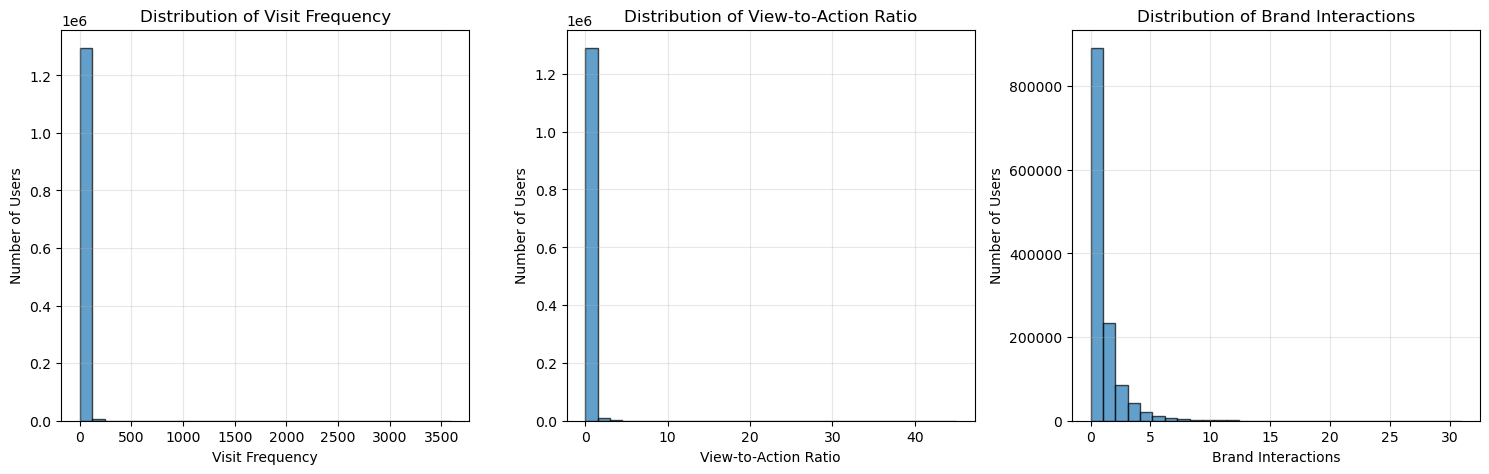

Feature correlations:
                      visit_frequency  view_to_action_ratio  \
visit_frequency              1.000000              0.061595   
view_to_action_ratio         0.061595              1.000000   
brand_interactions           0.588648             -0.042332   

                      brand_interactions  
visit_frequency                 0.588648  
view_to_action_ratio           -0.042332  
brand_interactions              1.000000  


In [21]:
# Step 2: Visualize the features
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(clustering_features['visit_frequency'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Visit Frequency')
plt.ylabel('Number of Users')
plt.title('Distribution of Visit Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(clustering_features['view_to_action_ratio'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('View-to-Action Ratio')
plt.ylabel('Number of Users')
plt.title('Distribution of View-to-Action Ratio')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(clustering_features['brand_interactions'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Brand Interactions')
plt.ylabel('Number of Users')
plt.title('Distribution of Brand Interactions')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show correlation between features
correlation_matrix = clustering_features[['visit_frequency', 'view_to_action_ratio', 'brand_interactions']].corr()
print("Feature correlations:")
print(correlation_matrix)

In [25]:
# Step 3: Prepare data for clustering
# Select features for clustering
X = clustering_features[['visit_frequency', 'view_to_action_ratio', 'brand_interactions']].copy()

# Handle any potential outliers or infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# Scale the features for K-means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features prepared for clustering:")
print(f"Shape: {X_scaled.shape}")
print(f"Features: {list(X.columns)}")

# Step 4: Elbow Method to find optimal number of clusters
print("\nRunning Elbow Method...")

k_range = range(2, 20)
inertias = []
silhouette_scores = []

# Calculate inertias and silhouette scores
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    
    # # Calculate silhouette score
    # if len(set(clusters)) > 1:  # Ensure we have more than 1 cluster
    #     sil_score = silhouette_score(X_scaled, clusters)
    #     silhouette_scores.append(sil_score)
    # else:
    #     silhouette_scores.append(0)

print("Elbow method completed!")

Features prepared for clustering:
Shape: (1300236, 3)
Features: ['visit_frequency', 'view_to_action_ratio', 'brand_interactions']

Running Elbow Method...
Elbow method completed!


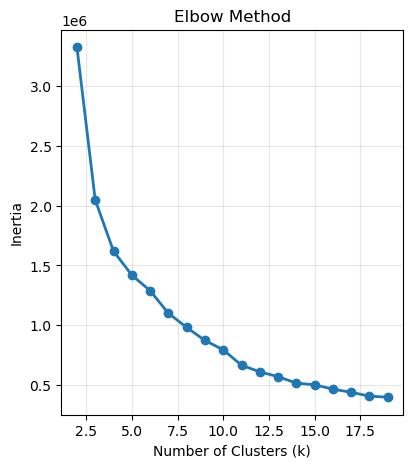

In [26]:
# Step 5: Visualize Elbow Method and Silhouette Analysis
plt.figure(figsize=(15, 5))

# Elbow Method
plt.subplot(1, 3, 1)
plt.plot(k_range, inertias, marker='o', linewidth=2)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True, alpha=0.3)

# # Silhouette Score
# plt.subplot(1, 3, 2)
# plt.plot(k_range, silhouette_scores, marker='o', color='orange', linewidth=2)
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Analysis')
# plt.grid(True, alpha=0.3)

# # Combined view
# plt.subplot(1, 3, 3)
# ax1 = plt.gca()
# line1 = ax1.plot(k_range, inertias, marker='o', color='blue', label='Inertia')
# ax1.set_xlabel('Number of Clusters (k)')
# ax1.set_ylabel('Inertia', color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')

# ax2 = ax1.twinx()
# line2 = ax2.plot(k_range, silhouette_scores, marker='s', color='orange', label='Silhouette Score')
# ax2.set_ylabel('Silhouette Score', color='orange')
# ax2.tick_params(axis='y', labelcolor='orange')

# plt.title('Combined Analysis')
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # Find optimal k
# optimal_k_silhouette = k_range[silhouette_scores.index(max(silhouette_scores))]

# print("CLUSTERING ANALYSIS RESULTS:")
# print("=" * 40)
# print(f"Optimal k based on Silhouette Score: {optimal_k_silhouette}")
# print(f"Maximum Silhouette Score: {max(silhouette_scores):.3f}")

# # Show detailed results
# results_df = pd.DataFrame({
#     'k': k_range,
#     'Inertia': inertias,
#     'Silhouette_Score': silhouette_scores
# })
# print("\nDetailed Results:")
# print(results_df)

In [27]:
# Step 6: Apply Final Clustering with Optimal k
final_k = 10  # Use the optimal k found

# Run final clustering
final_kmeans = KMeans(n_clusters=final_k, random_state=42)
final_clusters = final_kmeans.fit_predict(X_scaled)

# Add cluster labels to our features dataframe
clustering_features['cluster'] = final_clusters

print(f"Final clustering with k={final_k}")
print(f"Cluster distribution:")
print(clustering_features['cluster'].value_counts().sort_index())

# Analyze each cluster
print(f"\nCluster Analysis:")
print("=" * 50)

cluster_analysis = clustering_features.groupby('cluster').agg({
    'visit_frequency': ['mean', 'std', 'min', 'max'],
    'view_to_action_ratio': ['mean', 'std', 'min', 'max'],
    'brand_interactions': ['mean', 'std', 'min', 'max']
}).round(3)

print(cluster_analysis)

# Create cluster names based on characteristics
print(f"\nCLUSTER PROFILES:")
print("=" * 50)

for cluster_id in sorted(clustering_features['cluster'].unique()):
    cluster_data = clustering_features[clustering_features['cluster'] == cluster_id]
    
    avg_visits = cluster_data['visit_frequency'].mean()
    avg_ratio = cluster_data['view_to_action_ratio'].mean()
    avg_brands = cluster_data['brand_interactions'].mean()
    size = len(cluster_data)
    
    print(f"Cluster {cluster_id}: ({size:,} users)")
    print(f"  - Avg Visits: {avg_visits:.1f}")
    print(f"  - Avg View-to-Action Ratio: {avg_ratio:.3f}")
    print(f"  - Avg Brand Interactions: {avg_brands:.1f}")
    
    # Create profile name
    if avg_visits > clustering_features['visit_frequency'].median():
        visit_level = "High"
    else:
        visit_level = "Low"
        
    if avg_ratio > clustering_features['view_to_action_ratio'].median():
        engagement = "High Conversion"
    else:
        engagement = "Low Conversion"
        
    if avg_brands > clustering_features['brand_interactions'].median():
        brand_behavior = "Multi-Brand"
    else:
        brand_behavior = "Single-Brand"
    
    profile = f"{visit_level} Activity, {engagement}, {brand_behavior}"
    print(f"  - Profile: {profile}")
    print()

Final clustering with k=10
Cluster distribution:
cluster
0    928031
1     51679
2     99465
3     46547
4    149211
5       459
6       274
7      6209
8      8651
9      9710
Name: count, dtype: int64

Cluster Analysis:
        visit_frequency                     view_to_action_ratio         \
                   mean      std  min   max                 mean    std   
cluster                                                                   
0                 3.393    3.447    1    30                0.002  0.016   
1                44.644   21.645    6   116                0.066  0.132   
2                13.929   12.229    3    90                0.340  0.152   
3                 9.142    9.712    2   119                0.941  0.217   
4                15.889    9.146    3    53                0.030  0.074   
5               484.179  284.878  282  3590                0.106  0.246   
6                23.708   25.994    7   281                9.338  5.171   
7               158.010   47